In [12]:
from src.distributions import GaussianGenerator, SpiralGenerator, CheckerboardGenerator, MultiGaussGenerator
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch import autograd

from src.plotting import plot_meanflow_results
from src.plotting import plot_flow_results

# Data samplers

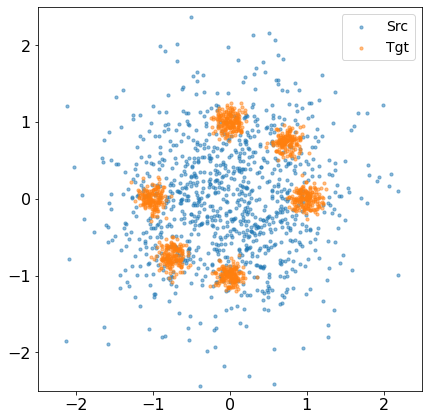

In [13]:
# Initialize
src_sampler = GaussianGenerator(noise_std=.75)
tgt_sampler = MultiGaussGenerator()

src = src_sampler.generate(1000)
tgt = tgt_sampler.generate(1000)
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(src[:, 0], src[:, 1], label='Src', alpha=0.5, s=10)
ax.scatter(tgt[:, 0], tgt[:, 1], label='Tgt', alpha=0.5, s=10)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_aspect('equal')
ax.legend(fontsize=14)


plt.tight_layout()
plt.show()

# Classical Flow Matching

In [14]:
class FlowNet(nn.Module):
    def __init__(self, input_dim, h_dim=64):
        super().__init__()
        self.fc_in  = nn.Linear(input_dim + 1, h_dim)
        self.fc2    = nn.Linear(h_dim, h_dim)
        self.fc3    = nn.Linear(h_dim, h_dim)
        self.fc_out = nn.Linear(h_dim, input_dim)

    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)
        x = torch.cat([x, t], dim=1)
        x = act(self.fc_in(x))
        x = act(self.fc2(x))
        x = act(self.fc3(x))
        return self.fc_out(x)

Training Progress: 100%|██████████| 1000/1000 [00:05<00:00, 189.16epoch/s, loss=0.71811]


Text(0, 0.5, 'Loss')

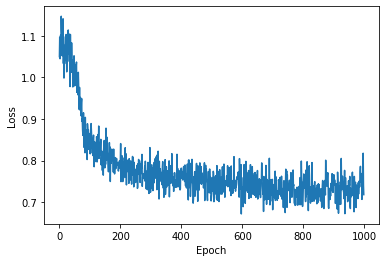

In [15]:
# Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 1000
batch_size = 1024
lr = 1e-3


net = FlowNet(input_dim=2).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss_history = []
pbar = tqdm(range(n_epochs), desc="Training Progress", unit="epoch")
for epoch in pbar:
    x0 = src_sampler.generate(batch_size).to(device)
    x1 = tgt_sampler.generate(batch_size).to(device)

    t = torch.rand(batch_size, 1).to(device)
    xt = (1 - t) * x0 + t * x1

    v_target = x1 - x0
    v_pred = net(xt, t)

    loss = F.mse_loss(v_pred, v_target)
    loss_history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_postfix(loss=f"{loss.item():.5f}")
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

Let's check that from one step it doesn't cover all modes 

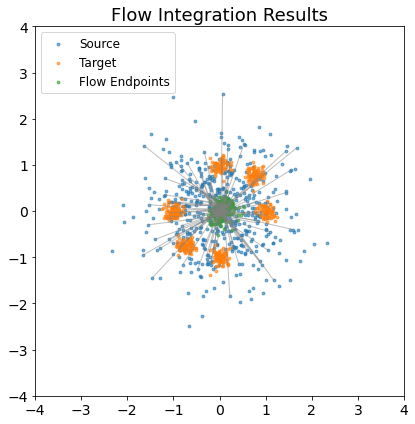

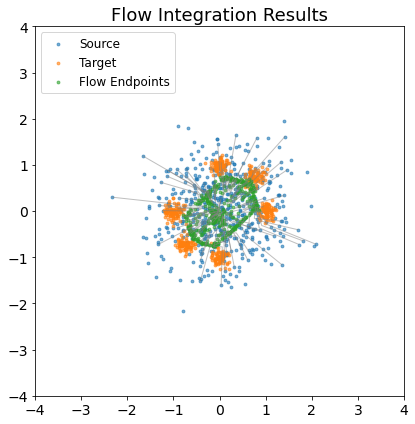

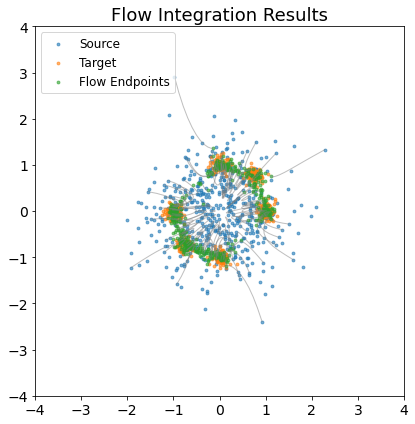

In [16]:
plot_flow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=1,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)
plot_flow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=2,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)
plot_flow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=10,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)


# Mean Flows 

In [17]:
class MeanFlowNet(nn.Module):
    def __init__(self, input_dim, h_dim=64):
        super().__init__()
        # Here two times are added to the input dimension
        # to account for the time and radius in the flow computation
        # however in case of more complex flows, you might want to adjust this to positional encodings or other features
        self.fc_in  = nn.Linear(input_dim + 2, h_dim)
        self.fc2    = nn.Linear(h_dim, h_dim)
        self.fc3    = nn.Linear(h_dim, h_dim)
        self.fc_out = nn.Linear(h_dim, input_dim)

    def forward(self, x, t, r, act=F.gelu):
        t = t.expand(x.size(0), 1)
        r = r.expand(x.size(0), 1)
        h = torch.cat([x, t, r], dim=1)
        h = act(self.fc_in(h))
        h = act(self.fc2(h))
        h = act(self.fc3(h))
        return self.fc_out(h)

# Loss needs JVM
here's the chat gpt description (lol, sorry)


## 🔍 Step-by-step: How `jvp` Works in PyTorch

### **1. Dual Tensors Are Created**

PyTorch internally uses **forward-mode automatic differentiation** by attaching **dual numbers** to each input tensor.

Each input $x_i$ is replaced by a **dual tensor**:

$$
x_i + \epsilon v_i
$$

This means each scalar in the input carries an extra slot for its **directional derivative**, initialized to $v_i$.

---

### **2. Forward Propagation Through the Function**

As the function `f(x)` is evaluated:

* Every operation is overloaded to **propagate both the primal value and the tangent (derivative)**.
* That is, for each intermediate result, PyTorch computes:

  * The normal value (e.g. $y = x^2$)
  * The directional derivative (e.g. $\dot{y} = 2x \cdot \dot{x}$)

This is **forward-mode autodiff**, implemented using internal `DualLevel` and `ForwardADLevel` contexts.

---

### **3. No Full Jacobian is Constructed**

PyTorch **does not compute or store** the full Jacobian matrix:

* Only **Jacobian-vector products** are propagated, using dual-number rules.
* This is **efficient for small input dimension → large output dimension** (the opposite of reverse-mode).

Example:
If $f: \mathbb{R}^d \to \mathbb{R}^m$, `jvp` returns:

$$
f(x), \quad \text{and} \quad J(x) \cdot v
$$

without ever forming $J(x)$ explicitly.

---

### **4. Only One Pass is Required**

Unlike reverse-mode backprop which traverses the graph twice:

* `jvp` only needs **one forward pass** to compute both the output and the directional derivative.
* Internally, this is done by **recording a special forward-mode context** for each tensor and propagating tangents.

---

## 🔧 Example:

```python
import torch
from torch.autograd.functional import jvp

def f(x):
    return x ** 3 + x

x = torch.tensor([2.0], requires_grad=True)
v = torch.tensor([1.0])

out, deriv = jvp(f, (x,), (v,))
print("f(x) =", out)       # = 8 + 2 = 10
print("df/dx · v =", deriv)  # = derivative of f(x)=x^3+x at x=2: 3x^2 + 1 = 13
```

---

## 🧬 Multi-variable example (e.g., Flow Matching):

Suppose you have a function that depends on $z, r, t$, and you want to compute the derivative in a specific direction:

```python
jvp(
    fn,                           # fn(z, r, t)
    (z, r, t),                    # inputs
    (v, torch.zeros_like(r), torch.ones_like(t)),  # direction
)
```

This computes:

$$
\frac{d}{d\epsilon} fn(z + \epsilon v, r + \epsilon·0, t + \epsilon·1)
$$

i.e., the directional derivative in the direction of increasing $z$ and $t$.

---


We need a special sampler for r,t that sometimes set them to be equal, in this case this reduces to classical FM

In [18]:
def sample_t_r(batch_size: int,device: torch.device,p_equal: float = 0.1):
    """
    Sample t and r for Mean‑Flow training.

    Args:
      batch_size:  number of (t,r) pairs
      device:      torch device
      p_equal:     fraction of samples where r == t

    Returns:
      t: Tensor of shape (batch_size, 1), with values in [0,1]
      r: Tensor of shape (batch_size, 1), with values in [0,1], and r <= t.
    """
    # 1) sample two uniforms and sort
    u = torch.rand(batch_size, 2, device=device)
    t = torch.max(u[:, 0], u[:, 1]).unsqueeze(1)  # larger of the two
    r = torch.min(u[:, 0], u[:, 1]).unsqueeze(1)  # smaller of the two

    # 2) randomly force r == t on a p_equal fraction
    if p_equal > 0:
        mask = torch.rand(batch_size, device=device) < p_equal
        # expand mask to shape (batch_size,1)
        mask = mask.unsqueeze(1)
        r = torch.where(mask, t, r)

    return t, r

We first set r_t_portion to be 1, this should result in the same picture as for Flow Matching

MeanFlow Training: 100%|██████████| 1000/1000 [00:07<00:00, 134.12it/s, loss=7.1621e-01]


Text(0, 0.5, 'Loss')

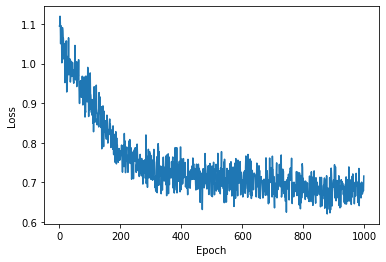

In [19]:
# Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 1000
batch_size = 1024
lr = 1e-3


net = MeanFlowNet(input_dim=2).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

r_t_portion = 1 # fraction of samples where r == t set to 1 to match flow matching

loss_history = []
pbar = tqdm(range(1, n_epochs + 1), desc='MeanFlow Training')
for epoch in pbar:
    # 1) sample source x0 and target x1
    x0 = src_sampler.generate(batch_size).to(device)
    x1 = tgt_sampler.generate(batch_size).to(device)
    v_t = x1 - x0  

    # 2) sample times t and r (0 <= r <= t <= 1)
    t, r = sample_t_r(batch_size, device, p_equal=1)
    
    # 3) form z_t by linear interpolation
    z_t = (1 - t) * x0 + t * x1
    z_t.requires_grad_(True)

    # 4) compute u and J_v + ∂ₜu via autograd.functional.jvp
    #    note: v-z part is v_t, time vector is ones, r-part zero
    jvp_args = (
        net,                      # function fn(z, t, r)
        (z_t, t, r),                 # inputs
        (v_t, torch.ones_like(t), torch.zeros_like(r))
    )
    u, jvp_out = torch.autograd.functional.jvp(*jvp_args, create_graph=True)

    # 5) build target: u_tgt = v_t - (t - r) * (Jv + ∂ₜu)
    u_tgt = v_t - (t - r) * jvp_out

    # 6) loss & step (stop‑gradient on u_tgt)
    loss = F.mse_loss(u, u_tgt.detach())
    loss_history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 7) update progress bar
    pbar.set_postfix(loss=f"{loss.item():.4e}")
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

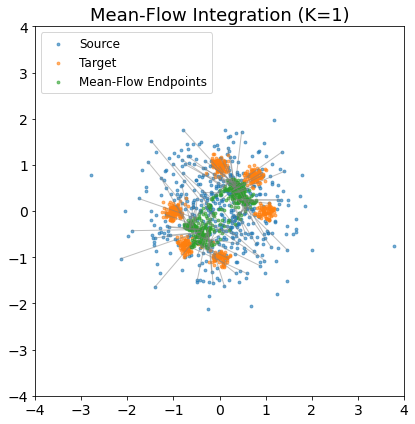

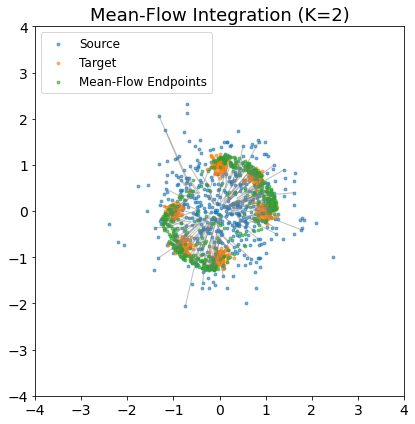

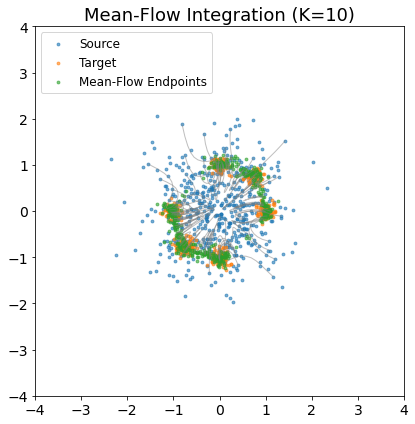

In [20]:
plot_meanflow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=1,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)
plot_meanflow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=2,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)
plot_meanflow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=10,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)


We indeed see that model doesn't cover all modes from 1 step

Now let's check with r_t_portion = 0.65

MeanFlow Training: 100%|██████████| 1000/1000 [00:07<00:00, 140.23it/s, loss=7.0868e-01]


Text(0, 0.5, 'Loss')

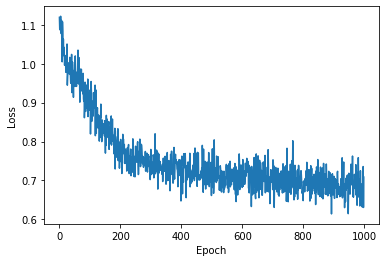

In [21]:
# Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 1000
batch_size = 1024
lr = 1e-3


net = MeanFlowNet(input_dim=2).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

r_t_portion = 0.65 # fraction of samples where r == t set to 1 to match flow matching

loss_history = []
pbar = tqdm(range(1, n_epochs + 1), desc='MeanFlow Training')
for epoch in pbar:
    # 1) sample source x0 and target x1
    x0 = src_sampler.generate(batch_size).to(device)
    x1 = tgt_sampler.generate(batch_size).to(device)
    v_t = x1 - x0  

    # 2) sample times t and r (0 <= r <= t <= 1)
    t, r = sample_t_r(batch_size, device, p_equal=1)
    
    # 3) form z_t by linear interpolation
    z_t = (1 - t) * x0 + t * x1
    z_t.requires_grad_(True)

    # 4) compute u and J_v + ∂ₜu via autograd.functional.jvp
    #    note: v-z part is v_t, time vector is ones, r-part zero
    jvp_args = (
        net,                      # function fn(z, t, r)
        (z_t, t, r),                 # inputs
        (v_t, torch.ones_like(t), torch.zeros_like(r))
    )
    u, jvp_out = torch.autograd.functional.jvp(*jvp_args, create_graph=True)

    # 5) build target: u_tgt = v_t - (t - r) * (Jv + ∂ₜu)
    u_tgt = v_t - (t - r) * jvp_out

    # 6) loss & step (stop‑gradient on u_tgt)
    loss = F.mse_loss(u, u_tgt.detach())
    loss_history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 7) update progress bar
    pbar.set_postfix(loss=f"{loss.item():.4e}")
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

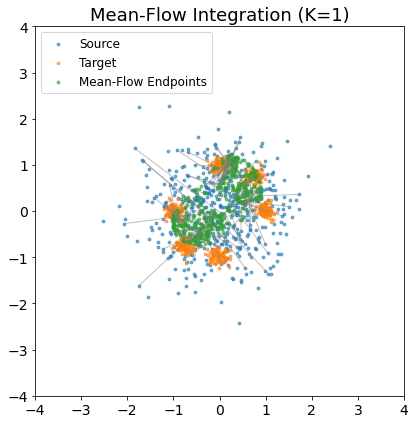

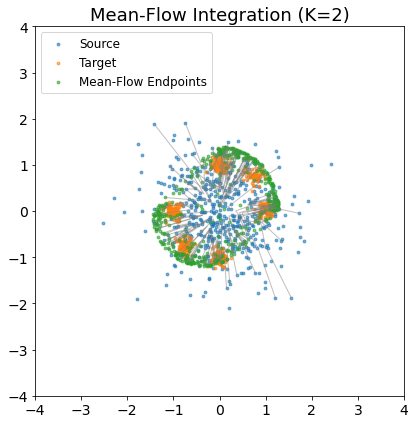

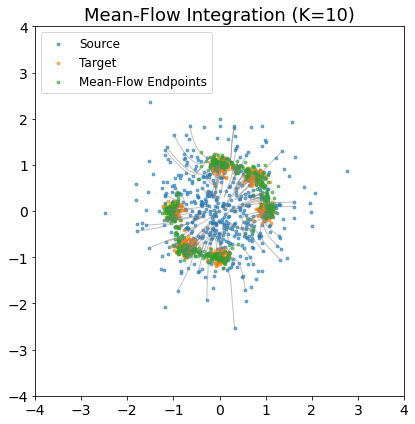

In [22]:
plot_meanflow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=1,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)
plot_meanflow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=2,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)
plot_meanflow_results(
    net=net,
    src_sampler=src_sampler,
    tgt_sampler=tgt_sampler,
    num_samples=500,
    K=10,          # number of nearest neighbors
    plot_trajs=True,   # turn on trajectories
    traj_count=100     # draw 100 sample-to-flow lines
)
